In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 23 15:33:48 2021

@author: srikanth subramanian
"""

import hexalattice.hexalattice as hex            #plotting as a hexagonal lattice
import numpy as np                               #matrix operations
import matplotlib.pyplot as plt                  #plotting tool
from pathlib import  Path
import imageio as iio
import pandas as pd                              #dataframe handling 
import seaborn as sns                            #nicers plotting
import glob
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from natsort import natsorted

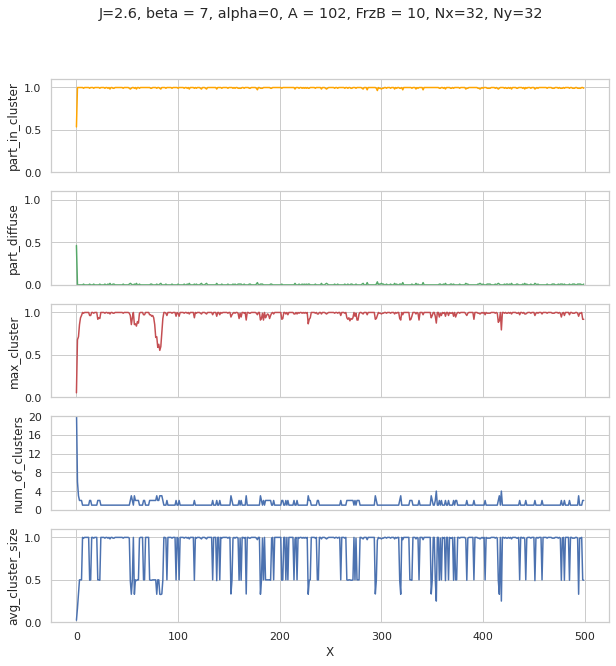

In [13]:
"""
Plot features as a function of monte carlo time from a single simulation 
"""


sns.set(font_scale=1)  # Set the desired font scale
sns.set_style("whitegrid")
# sns.despine()
density = 0.1
dnum_avg_cluster_size =[] #average cluster size 
dnum_of_clusters = []     #number of clusters
dnum_max_cluster = []     #size of max cluster
dpart_in_clusters = []    #number of particles in cluster
dpart_dif = []            #number of diffuse particles
X = []
run = 100                  #Folder number
alpha = 0                 
for J in [2.6]:           #J_aa
    for beta in [7]:    #J_ab
        for FrzB in [10]:  #Number of FrzB
            for index in [3]: #Simulation index
                
 
                labels = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Frz = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_flags_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Path(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}').mkdir(exist_ok=True)
                Nx,Ny = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,max_rows=1)
                
                N = density*Nx*Ny+FrzB             #Total number of particles= N_A + N_B
                saved_steps = int(labels.shape[0]/3)
                
                num_of_clusters=[]
                num_part_max_cluster=[]
                part_in_clusters=[]
                part_dif=[]
                avg_cluster_size=[]
                for i in range(saved_steps):

                    num_of_clusters=np.append(num_of_clusters,np.max(labels[i*3]))
                    q=0
                    p=0
                    for j in range(labels.shape[1]):
                        if labels[i*3+2,j]>1:

                            q+=1
                        if labels[i*3+2,j]==1:
                            p+=1
                    part_in_clusters=np.append(part_in_clusters,q)
                    part_dif=np.append(part_dif,p)
                    u = np.bincount(labels[i*3])
                    num_part_max_cluster = np.append(num_part_max_cluster,u[1:].max())
                    avg_cluster_size = np.append(avg_cluster_size,np.mean(u[1:]))
                                                

                    
            dnum_max_cluster = np.append(dnum_max_cluster,num_part_max_cluster)/N
            dnum_avg_cluster_size = np.append(dnum_avg_cluster_size, avg_cluster_size)/N
            dnum_of_clusters=np.append(dnum_of_clusters,num_of_clusters)
            dpart_in_clusters=np.append(dpart_in_clusters ,part_in_clusters)/N
            dpart_dif=np.append(dpart_dif ,part_dif)/N
            
            #Plots 
            X=np.append(X,np.arange(0,saved_steps,1))
            dtraj_long = {"X":X,"part_in_cluster":dpart_in_clusters,"part_diffuse":dpart_dif,"num_of_clusters":dnum_of_clusters,"max_cluster":dnum_max_cluster,"avg_cluster_size":dnum_avg_cluster_size}
            traj_long = pd.DataFrame(data=dtraj_long) #Create a data_structure with MCS on one column and append observables


            fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
            fig.suptitle(f'J={J}, beta = {beta}, alpha={alpha}, A = {int(N-FrzB)}, FrzB = {FrzB}, Nx={Nx}, Ny={Ny}')
            sns.lineplot(data=traj_long,x='X',y='part_in_cluster',color='orange', errorbar='sd', ax=axs[0])
            sns.lineplot(data=traj_long,x='X',y='part_diffuse',color='g', errorbar='sd',ax=axs[1]) 
            sns.lineplot(data=traj_long,x='X',y='max_cluster',color='r', errorbar='sd',ax=axs[2])
            sns.lineplot(data=traj_long,x='X',y='num_of_clusters',color='b', errorbar='sd',ax=axs[3])
            sns.lineplot(data=traj_long,x='X',y='avg_cluster_size',color='b', errorbar='sd',ax=axs[4])
                
            axs[0].set_ylim([0,1+0.1])
            axs[1].set_ylim([0,1+0.1])
            axs[2].set_ylim([0,1+0.1])
            axs[3].set_ylim([0,dnum_of_clusters.max()/2])            
            axs[3].set_yticks(np.arange(0,dnum_of_clusters.max(),4))
            axs[4].set_ylim([0,1+0.1])
           
            plt.savefig(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}/quantities_time_series.pdf')
                
            plt.show()


In [19]:
"""
Phase diagram calculations across J_AA and J_AB
"""
theta = {}
max_cluster = {}
two_max_cluster = {}

sns.set(font_scale=1.2)  # Set the desired font scale
sns.set_style("whitegrid")
# sns.despine()
density = 0.1

# Parameters
order_parameter_mean = []
dnum_2nd_max_cluster_mean = []
run = 40
params = [2,2.5,3,3.5,4] #J_AA Parameters
params1 = [2,2.5,3,3.5,4,5,6,7,8] #J_AB Parameters 
alpha = 0

theta_mat = np.zeros((len(params),len(params1)))
max_cluster_mat = np.zeros((len(params),len(params1)))
sec_max_cluster_mat = np.zeros((len(params),len(params1)))
num_cluster_mat = np.zeros((len(params),len(params1)))


for FrzB in [30]:
    for J in params:
        for beta in params1:
            order_parameter = 0
            one = 0
            two = 0
            clusters = 0
            num_cluster = []
            num_part_max_cluster = []
            num_part_2nd_max_cluster = []
            for index in np.arange(1,11,1):
                
                labels = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Frz = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_flags_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Path(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}').mkdir(exist_ok=True)
                Nx,Ny = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,max_rows=1)
                
                N = density*Nx*Ny+FrzB
                saved_steps = int(labels.shape[0]/3)
                                
                num_part_max_cluster=[]
                num_part_2nd_max_cluster = []
                
                for i in range(saved_steps):
                    
                    u = np.bincount(labels[i*3])
                    u = np.sort(u)[::-1]
                    
                    num_part_max_cluster = np.append(num_part_max_cluster,u[0])
                    num_part_2nd_max_cluster = np.append(num_part_2nd_max_cluster,u[1])
                    num_cluster = np.append(num_cluster,len(u[u>N/10]))

                temp_1 = np.mean(num_part_max_cluster[200:-1:10]*2)/N
                temp_2 = np.mean(num_part_2nd_max_cluster[200:-1:10]*2)/N
                order_parameter += temp_1*temp_2
                one += temp_1
                two += temp_2
                clusters += np.mean(num_cluster[200:-1:10])

            theta_mat[params.index(J),params1.index(beta)] = order_parameter/10
            max_cluster_mat[params.index(J),params1.index(beta)] = one/10
            sec_max_cluster_mat[params.index(J),params1.index(beta)] = two/10
            num_cluster_mat[params.index(J),params1.index(beta)] = clusters/10
            
            print(J,beta,num_cluster_mat[params.index(J),params1.index(beta)])
    theta[FrzB] = theta_mat
    max_cluster[FrzB] = max_cluster_mat
    two_max_cluster[FrzB] = sec_max_cluster_mat

# print(order_parameter_mean)            

2 2 1.9847211697340086
2 2.5 1.8474058304632117
2 3 1.3344018829741384
2 3.5 1.109216611160261
2 4 1.1137923918667025
2 5 1.2749087548747293
2 6 1.7556934601683416
2 7 2.395843065151843
2 8 2.955140165263163
2.5 2 2.0044925927436172
2.5 2.5 2.0152504245402776
2.5 3 1.8239183007469353
2.5 3.5 1.3225519216221546
2.5 4 1.115866799333685
2.5 5 1.0926785088577304
2.5 6 1.1752696742963693
2.5 7 1.5656975109694495
2.5 8 2.248848557152732
3 2 2.1686561552645047
3 2.5 2.167998647427231
3 3 2.055411217000409
3 3.5 1.7928825538400601
3 4 1.4991204789414372
3 5 1.3978804564763934
3 6 1.6191038573452694
3 7 1.8393848220566795
3 8 2.622904421917081
3.5 2 2.7102361450274013
3.5 2.5 3.011984105729682
3.5 3 2.8054857033853624
3.5 3.5 2.3313220169522055
3.5 4 2.275739150871096
3.5 5 2.6218478032265216
3.5 6 2.347697271659241
3.5 7 2.9007438155775125
3.5 8 2.805592596751429
4 2 3.769194053958535
4 2.5 3.6357984732119624
4 3 3.552015938501124
4 3.5 3.3051628177720787
4 4 3.340053954927132
4 5 3.4159934096

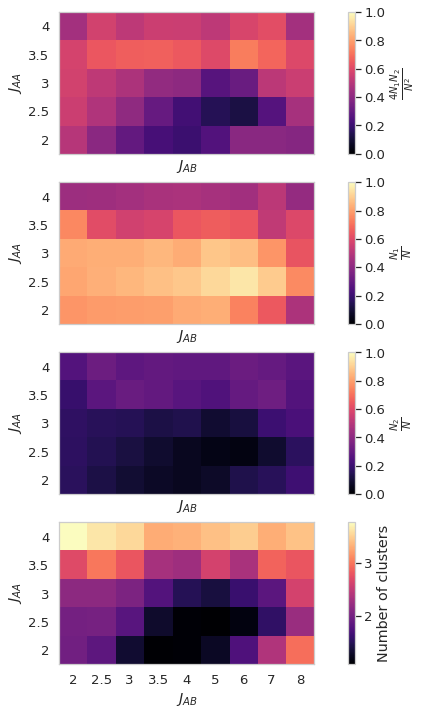

In [21]:
# Load the Series from the HDF5 file
# data = pd.read_hdf('data/data.h5', key='data_series')

df1 = pd.DataFrame(theta[30])
df2 = pd.DataFrame(max_cluster_mat/2)
df3 = pd.DataFrame(sec_max_cluster_mat/2)
df4 = pd.DataFrame(num_cluster_mat)
fig, axs = plt.subplots(4, sharex=True, figsize=(12,12))

labels = [str(i) for i in params]
labels1 = [str(i) for i in params1]

im1 = axs[0].imshow(df1, cmap='magma', interpolation='nearest')
cbar1 = plt.colorbar(im1, ax=axs[0])  # Set the lower and upper limits
im1.set_clim(0,1)
cbar1.set_label(r"$\frac{4N_1 N_2}{N^2}$")

axs[0].set_xticks(range(df1.shape[1]))
axs[0].set_yticks(range(df1.shape[0]))
axs[0].set_xlabel(r'$J_{AB}$')
axs[0].set_ylabel(r'$J_{AA}$')
axs[0].invert_yaxis()
axs[0].set_xticklabels(labels1)
axs[0].set_yticklabels(labels)
axs[0].grid(False)

im2 = axs[1].imshow(df2, cmap='magma', interpolation='nearest')
cbar2 = plt.colorbar(im2, ax=axs[1])
cbar2.set_label(r"$\frac{N_1}{N}$")
im2.set_clim(0,1)
axs[1].set_xticks(range(df2.shape[1]))
axs[1].set_yticks(range(df2.shape[0]))
axs[1].set_xlabel(r'$J_{AB}$')
axs[1].set_ylabel(r'$J_{AA}$')
axs[1].invert_yaxis()
axs[1].set_xticklabels(labels1)
axs[1].set_yticklabels(labels)
axs[1].grid(False)

im3 = axs[2].imshow(df3, cmap='magma', interpolation='nearest')
cbar3 = plt.colorbar(im3, ax=axs[2])
im3.set_clim(0, 1)
cbar3.set_label(r"$\frac{N_2}{N}$")
axs[2].set_xticks(range(df3.shape[1]))
axs[2].set_yticks(range(df3.shape[0]))
axs[2].set_xlabel(r'$J_{AB}$')
axs[2].set_ylabel(r'$J_{AA}$')
axs[2].invert_yaxis()
axs[2].set_xticklabels(labels1)
axs[2].set_yticklabels(labels)
axs[2].grid(False)

im4 = axs[3].imshow(df4, cmap='magma', interpolation='nearest')
cbar3 = plt.colorbar(im4, ax=axs[3])
# im4.set_clim(0, 1)
cbar3.set_label('Number of clusters')
axs[3].set_xticks(range(df3.shape[1]))
axs[3].set_yticks(range(df3.shape[0]))
axs[3].set_xlabel(r'$J_{AB}$')
axs[3].set_ylabel(r'$J_{AA}$')
axs[3].invert_yaxis()
axs[3].set_xticklabels(labels1)
axs[3].set_yticklabels(labels)
axs[3].grid(False)

# Adjust the layout and display the figure
# plt.tight_layout()
# plt.show()

plt.savefig(f'/scratch2/Srikanth/chemotactic_clusters/{run}/Order_parameter_beta_J.pdf')
# plt.show()


In [24]:
"""
Phase diagram calculations across FrzB with fixed J_AA and J_AB
"""
theta = {}
max_cluster = {}
two_max_cluster = {}

sns.set(font_scale=1.2)  # Set the desired font scale
sns.set_style("whitegrid")
sns.despine()
density = 0.1

# Parameters
order_parameter_mean = []
dnum_2nd_max_cluster_mean = []
run = 65
# params = [2,2.5,3,3.5,4]
# params1 = [2,2.5,3,3.5,4,5,6,7,8]
alpha = 0
FrzB_n = [1,10,20,30,40,50,70,80]
# FrzB_n = [1,10,40,50,60,100]
# FrzB_n = [1]
theta_list = np.zeros(len(FrzB_n))
max_cluster_list = np.zeros(len(FrzB_n))
sec_max_cluster_list = np.zeros(len(FrzB_n))
num_cluster_list = np.zeros(len(FrzB_n))
n_cluster_list = []

for J in [3]:
    for beta in [1]:
        for FrzB in FrzB_n:
            order_parameter = 0
            one = 0
            two = 0
            clusters = 0
            num_cluster = []
            num_part_max_cluster = []
            num_part_2nd_max_cluster = []
            max_cluster_time_series = np.zeros(saved_steps)
            
            for index in np.arange(1,4,1):
                
                labels = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Frz = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_flags_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Path(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}').mkdir(exist_ok=True)
                Nx,Ny = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,max_rows=1)
                
                N = density*Nx*Ny+FrzB
                saved_steps = int(labels.shape[0]/3)
                                
                num_part_max_cluster=[]
                num_part_2nd_max_cluster = []
                
                for i in range(saved_steps):
                    ui = labels[i*3]
                    u = np.bincount(ui[ui!=0])
                    u = np.sort(u)[::-1]
                    
                    num_part_max_cluster = np.append(num_part_max_cluster,u[0])
                    num_part_2nd_max_cluster = np.append(num_part_2nd_max_cluster,u[1])
                    num_cluster = np.append(num_cluster,len(u[u>N/10]))
                    

                temp_1 = np.mean(num_part_max_cluster[480:-1:10]*2)/N
                temp_2 = np.mean(num_part_2nd_max_cluster[480:-1:10]*2)/N
                order_parameter += temp_1*temp_2
                one += temp_1
                two += temp_2
                clusters += np.mean(num_cluster[480:-1:10])
                max_cluster_time_series += num_part_max_cluster
            theta_list[FrzB_n.index(FrzB)] = order_parameter/3
            max_cluster_list[FrzB_n.index(FrzB)] = one/3
            sec_max_cluster_list[FrzB_n.index(FrzB)] = two/3
            num_cluster_list[FrzB_n.index(FrzB)] = clusters/3
            n_cluster_list = np.append(n_cluster_list,clusters/3)
            max_cluster_time_series = max_cluster_time_series/3
            print(J,beta,max_cluster_list[FrzB_n.index(FrzB)])
    theta[FrzB] = theta_list
    max_cluster[FrzB] = max_cluster_list
    two_max_cluster[FrzB] = sec_max_cluster_list


3 1 1.9696969696969697
3 1 1.8416370106761566
3 1 1.6911764705882353
3 1 1.5735146022155087
3 1 1.4864232209737827
3 1 1.3976377952755907
3 1 1.2606341840680586
3 1 1.1951754385964912


<Figure size 432x288 with 0 Axes>

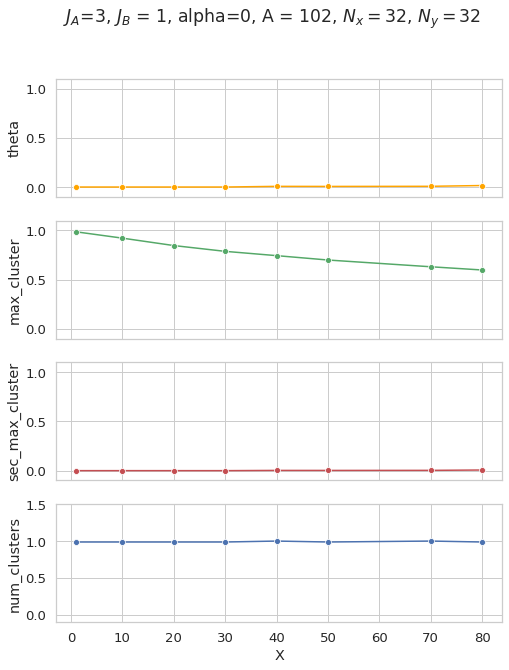

In [25]:
"""Plotting Equilibrium quantitites"""
X = FrzB_n
dtraj_long = {"X":X,"theta":theta_list,"max_cluster":max_cluster_list/2,"sec_max_cluster":sec_max_cluster_list/2,"num_clusters":num_cluster_list}
traj_long = pd.DataFrame(data=dtraj_long)

fig, axs = plt.subplots(4, sharex=True, figsize=(8,10))
fig.suptitle(f'$J_A$={J}, $J_B$ = {beta}, alpha={alpha}, A = {int(N-FrzB)}, $N_x=${Nx}, $N_y=${Ny}')
sns.lineplot(data=traj_long,x='X',y='theta',color='orange', errorbar='sd', ax=axs[0],marker='o')
sns.lineplot(data=traj_long,x='X',y='max_cluster',color='g', errorbar='sd',ax=axs[1],marker='o') 
sns.lineplot(data=traj_long,x='X',y='sec_max_cluster',color='r', errorbar='sd',ax=axs[2],marker='o')
sns.lineplot(data=traj_long,x='X',y='num_clusters',color='b', errorbar='sd',ax=axs[3],marker='o')
                
axs[0].set_ylim([0-0.1,1+0.1])
axs[1].set_ylim([0-0.1,1+0.1])
axs[2].set_ylim([0-0.1,1+0.1])
axs[3].set_ylim([0-0.1,num_cluster_list.max()+0.5])            
# axs[3].set_yticks(np.arange(0,num_cluster_list.max(),4))


# plt.savefig(f'/scratch2/Srikanth/chemotactic_clusters/{run}/Average_quantities_Jaa={J}, Jab = {beta}.pdf')
plt.show()


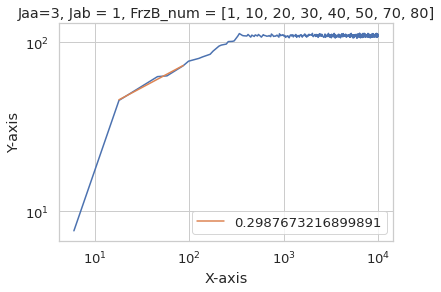

In [26]:
"""Coarsening timescale"""
time = np.arange(0,len(num_part_max_cluster))*2*10^6
y = max_cluster_time_series
plt.loglog(time,y)
# plt.ylim([0,1])

# Perform linear regression on log-transformed data
log_x = np.log(time[1:5])
log_y = np.log(y[1:5])
coeffs = np.polyfit(log_x, log_y, 1)
slope = coeffs[0]
intercept = coeffs[1]

# Plot the linear fit
fit_x = np.linspace(min(log_x), max(log_x), 100)
fit_y = slope * fit_x + intercept
plt.loglog(np.exp(fit_x), np.exp(fit_y), '-', label=f'{slope}')

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Jaa={J}, Jab = {beta}, FrzB_num = {FrzB_n}')

plt.legend()
plt.savefig(f'/scratch2/Srikanth/chemotactic_clusters/{run}/max_cluster_scaling_Jaa={J}, Jab = {beta},  FrzB_num = {FrzB_n}.pdf')
plt.show()

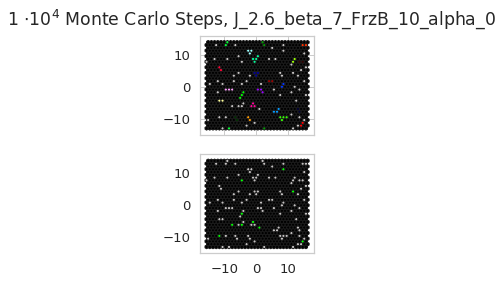

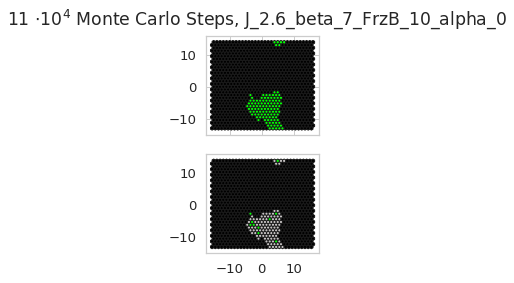

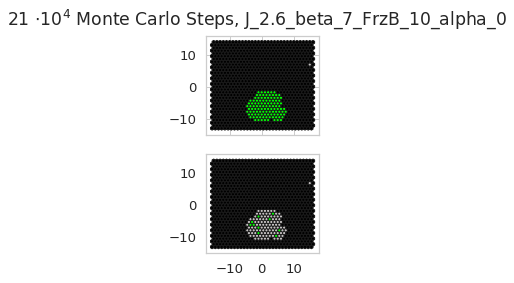

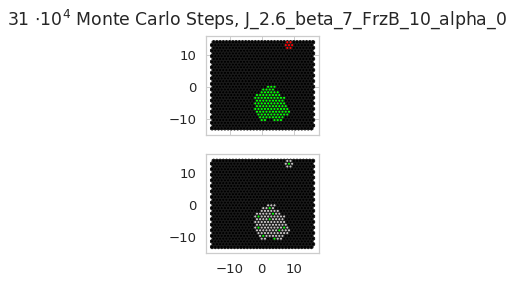

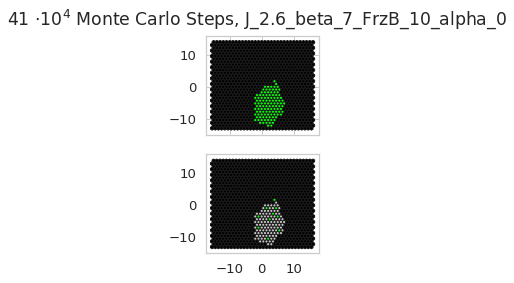

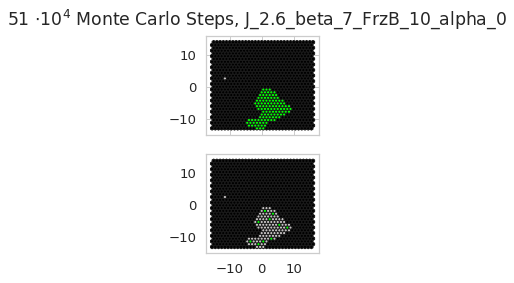

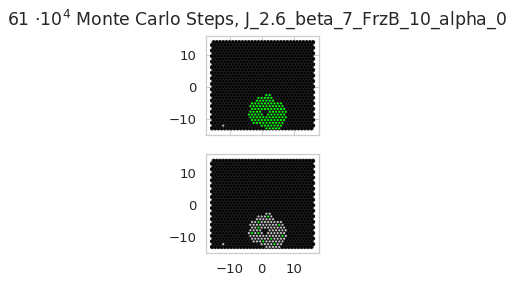

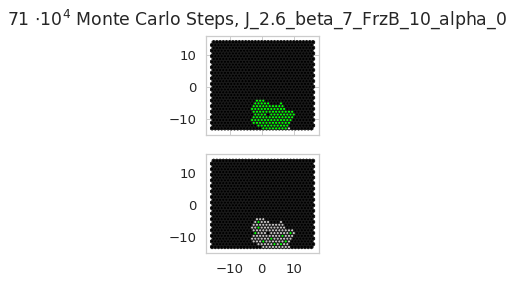

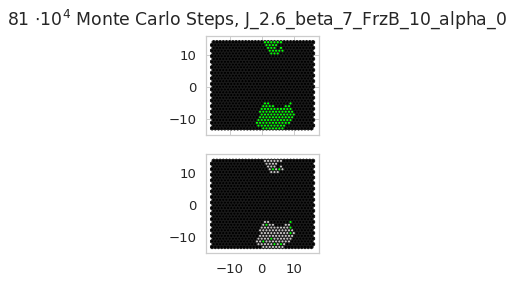

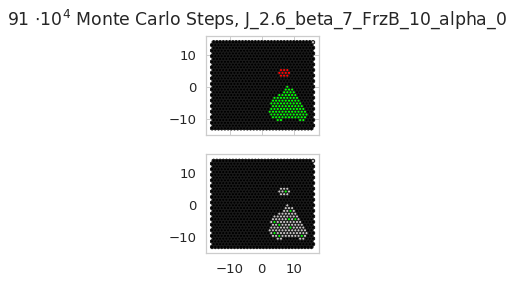

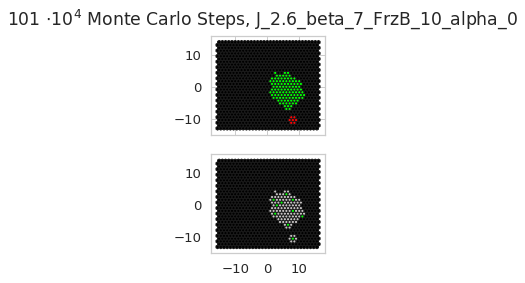

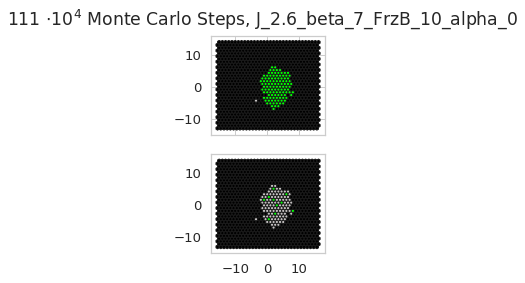

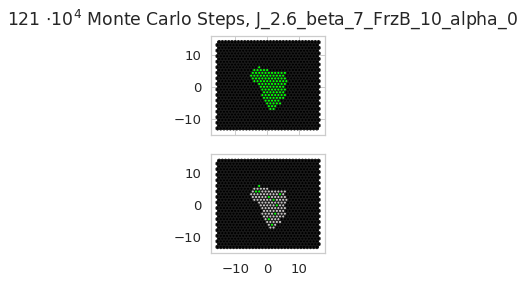

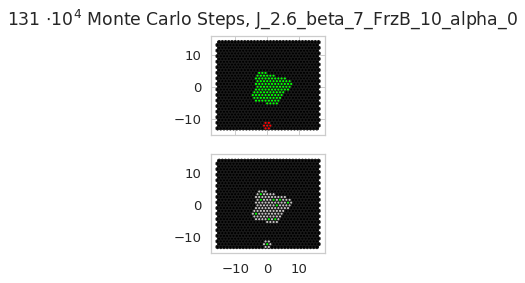

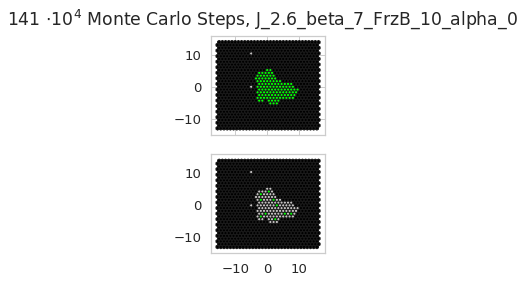

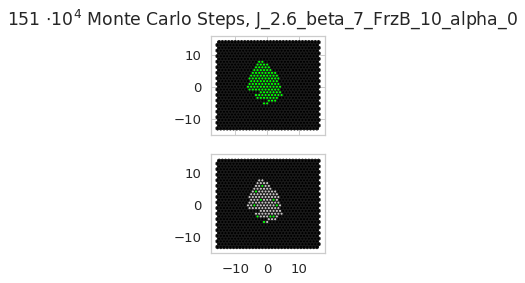

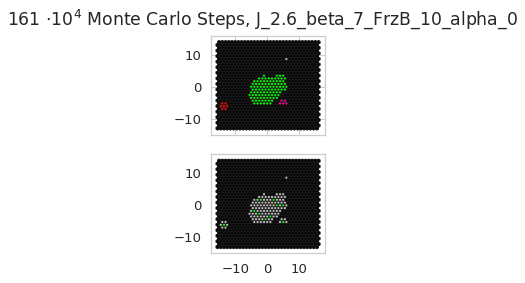

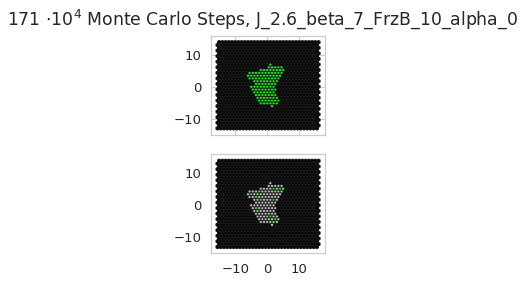

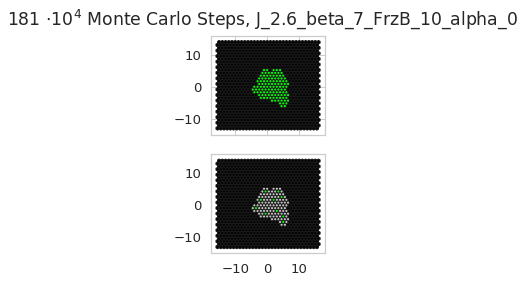

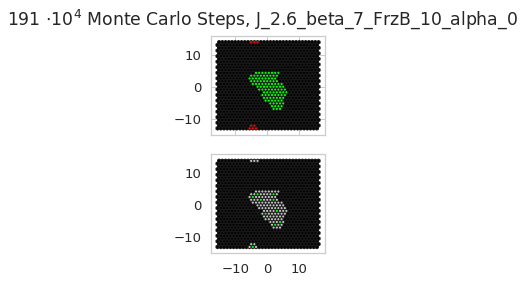

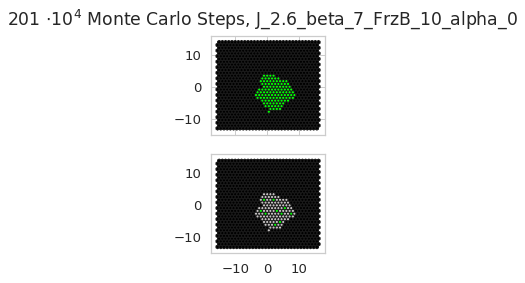

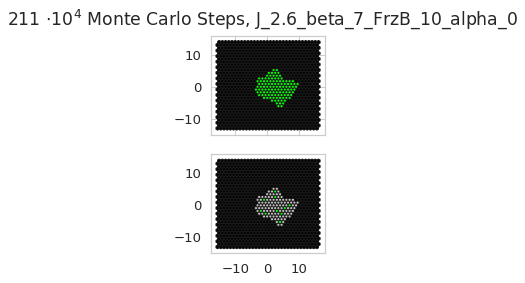

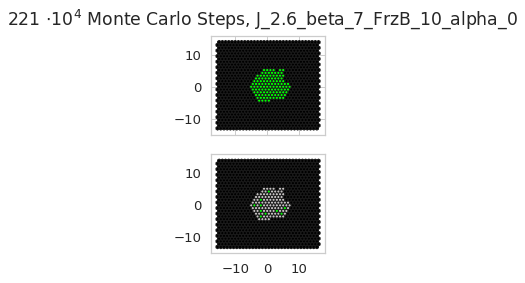

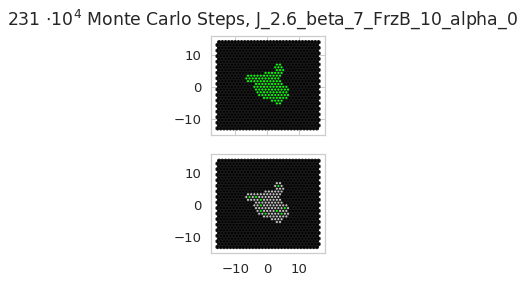

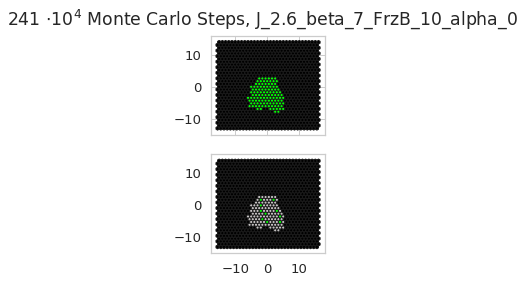

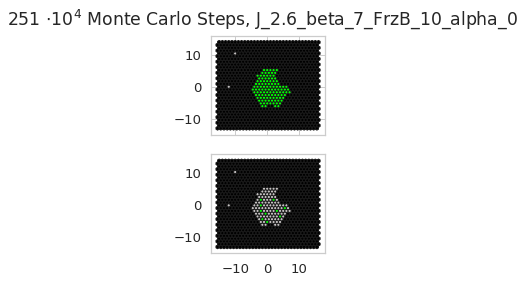

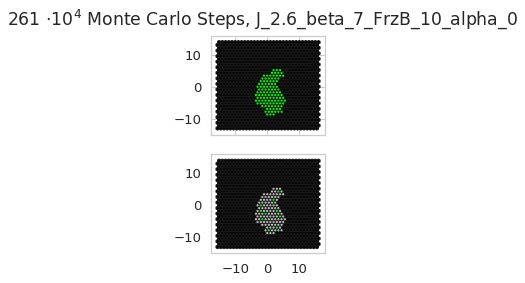

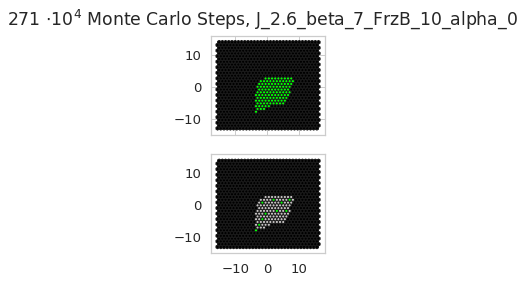

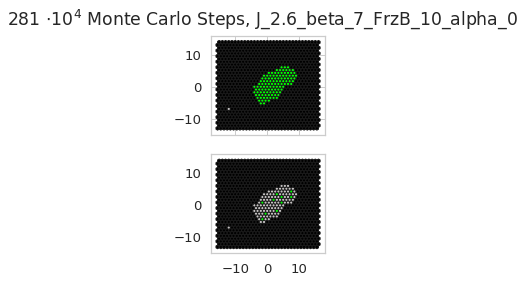

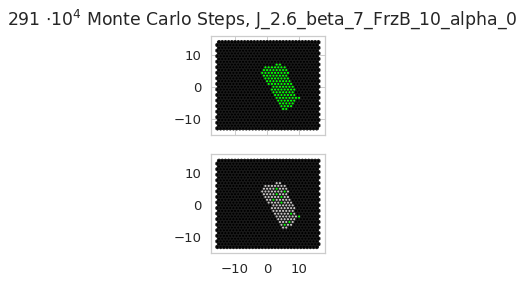

In [ ]:
# Visualizing the particles on a 2D Hexagonal Lattice

color_scale=[[0,0,1],[0,1,0],[1,0,0],[1,0,0.6],[1,0.6,0],[0.6,1,0],[0,1,0.6],[0,0.6,1],[0.6,0,1],[1,1,0.6],[1,0.6,1],[0.6,1,1],[0,0,0.6],[0,0.6,0],[0.6,0,0],
             [0,0,0.2],[0,0.2,0],[0.2,0,0],[1,0,0.2],[1,0.2,0],[0.2,1,0],[0,1,0.2],[0,0.2,1],[0.2,0,1],[1,1,0.2],[1,0.2,1],[0.2,1,1],
             [0,0.4,0.2],[0,0.2,0.4],[0.2,0.4,0],[0.4,0,0.2],[0.4,0.2,0],[0.2,0.4,0],[0.4,0.4,0.2],[0.4,0.2,0.4],[0.2,0.4,0.4],[0.4,1,0.2],[0.4,0.2,1],[0.2,1,0.4]]
alpha = 0
density = 0.1
run = 100
off = 0.03
# Frz_list= [5,10,15,20,25,30,35,40]
# Frz_list = [20,40,60,80,100,120,140,160,180]
for index in [2]:
    for J in [2.6]:
        for beta in [7]:
            for FrzB in [10]:
                
                labels = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Frz = np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_flags_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,skiprows=1)
                Path(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}').mkdir(exist_ok=True)
                Nx,Ny=np.loadtxt(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}.txt',dtype=int,max_rows=1)
                saved_steps = int(labels.shape[0]/3)
                
                for step in range(0,saved_steps,10):
                
                
                    colors_labels = np.zeros([int(Nx)*int(Ny),3])
                    coloring_labels = np.zeros([int(Nx)*int(Ny),3])
                    colors_Frz=np.zeros([int(Nx)*int(Ny),3])
                    i=0
                    j=0
                    ii=0

                    for x in labels[step*3+1]:
                        if labels[step*3,j]==0:
                            coloring_labels[x]=[195/255,192/255,192/255] 
                        else:
                            coloring_labels[x]=color_scale[labels[step*3,j]%39]
                        j+=1
                    fig, axs = plt.subplots(2,sharex=(True))
                    # plt.figure(figsize=(20,15))
                    hex_centers, _ = hex.create_hex_grid(nx= int(Nx),ny=int(Ny), face_color=coloring_labels,do_plot=True,h_ax=axs[0])

                    fig.suptitle(f'{(step+1)} $\cdot 10^4$ Monte Carlo Steps, J_{J}_beta_{beta}_FrzB_{FrzB}_alpha_{alpha}')
                    for x in labels[step*3+1]:

                        # else:
                        #     coloring_labels[x]=[195/255,192/255,192/255]
                            # labels_name[x]=labels[0,i]
                        if Frz[step,ii]==0:
                            colors_Frz[x]=[195/255,192/255,192/255]  
                        elif Frz[step,ii]==1:
                            colors_Frz[x]=[0, 1, 0]
                        elif Frz[step,ii]==2:
                            colors_Frz[x]=[0, 0, 1]
                        elif Frz[step,ii]==3:
                            colors_Frz[x]=[1, 0, 0]
                        ii+=1



                    hex_centers, axs[1] = hex.create_hex_grid(nx= int(Nx),ny=int(Ny), face_color=colors_Frz,do_plot=True,h_ax=axs[1])

                    axs[1].grid(False)


                    plt.savefig(f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}/Frz_B_{step}.jpg')
                    plt.show()
            
            # Directory containing the input images
                input_dir = f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}'

                # Get a list of all image file names in the directory
                image_files = natsorted([f for f in os.listdir(input_dir) if f.endswith('.jpg') or f.endswith('.png')])

                # Create a list to hold the image data
                image_data = []

                # Iterate through the input images and read them
                for image_file in image_files:
                    image_path = os.path.join(input_dir, image_file)
                    image = imageio.imread(image_path)
                    image_data.append(image)

                # Save the image data as a GIF
                output_path = input_dir+'/output.gif'  # Output GIF file name
                fps = 5 # Frames per second for the output GIF
                imageio.mimsave(output_path, image_data, fps=fps)


In [ ]:
import imageio
import os
from natsort import natsorted
alpha = 0
density = 0.1
run = 40
off = 0.03

for index in [1]:
    for J in [4]:
        for beta in [2*J]:
            for FrzB in [40]:
                # Directory containing the input images
                input_dir = f'/scratch2/Srikanth/chemotactic_clusters/{run}/{index}_dFrzB_labels_J_{J}_alpha_{alpha}_FrzB_{FrzB}_beta_{beta}'

                # Get a list of all image file names in the directory
                image_files = natsorted([f for f in os.listdir(input_dir) if f.endswith('.jpg') or f.endswith('.png')])

                # Create a list to hold the image data
                image_data = []

                # Iterate through the input images and read them
                for image_file in image_files:
                    image_path = os.path.join(input_dir, image_file)
                    image = imageio.imread(image_path)
                    image_data.append(image)

                # Save the image data as a GIF
                output_path = input_dir+'/output.gif'  # Output GIF file name
                fps = 5 # Frames per second for the output GIF
                imageio.mimsave(output_path, image_data, fps=fps)